In [3]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from torch import nn

from skimage import io
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from datasets import load_dataset

import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter

import torch
import evaluate
from transformers import Trainer

%matplotlib inline

In [4]:
# Get dataset
hf_dataset_identifier = "Adriatogi/graffiti"
ds = load_dataset(hf_dataset_identifier)
ds['data'] = ds['data'].rename_column('image', 'pixel_values')

In [5]:
# split data
ds = ds['data'].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

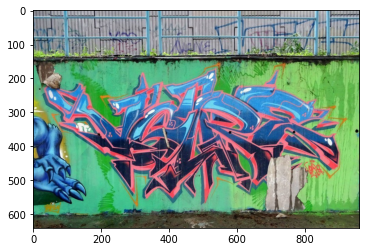

In [6]:
plt.imshow(train_ds[4]['pixel_values'])

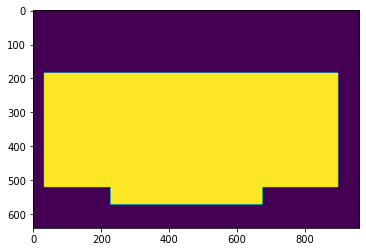

In [7]:
plt.imshow(train_ds[4]['label'])

In [8]:
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print(id2label)
print(num_labels)

{0: 'not_graf', 1: 'graf'}
2


In [19]:
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 
processor = SegformerImageProcessor(reduce_labels=True)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [20]:
pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments

epochs = 10
lr = 0.0001
batch_size = 1

hub_model_id = "segformer-b0-finetuned-segments-graffiti"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-graffiti-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [22]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

  0%|          | 1/960 [00:00<13:46,  1.16it/s] 

{'loss': 0.5944, 'learning_rate': 9.989583333333333e-05, 'epoch': 0.01}


  0%|          | 2/960 [00:01<13:33,  1.18it/s] 

{'loss': 0.5756, 'learning_rate': 9.979166666666668e-05, 'epoch': 0.02}


  0%|          | 3/960 [00:02<13:09,  1.21it/s] 

{'loss': 0.5114, 'learning_rate': 9.96875e-05, 'epoch': 0.03}


  0%|          | 4/960 [00:03<12:59,  1.23it/s] 

{'loss': 0.4513, 'learning_rate': 9.958333333333335e-05, 'epoch': 0.04}


  1%|          | 5/960 [00:04<13:07,  1.21it/s] 

{'loss': 0.3546, 'learning_rate': 9.947916666666666e-05, 'epoch': 0.05}


  1%|          | 6/960 [00:05<13:24,  1.19it/s] 

{'loss': 0.365, 'learning_rate': 9.9375e-05, 'epoch': 0.06}


  1%|          | 7/960 [00:05<13:55,  1.14it/s] 

{'loss': 0.4247, 'learning_rate': 9.927083333333333e-05, 'epoch': 0.07}


  1%|          | 8/960 [00:06<14:05,  1.13it/s] 

{'loss': 0.4178, 'learning_rate': 9.916666666666667e-05, 'epoch': 0.08}


  1%|          | 9/960 [00:07<13:51,  1.14it/s] 

{'loss': 0.2582, 'learning_rate': 9.90625e-05, 'epoch': 0.09}


  1%|          | 10/960 [00:08<13:18,  1.19it/s]

{'loss': 0.3169, 'learning_rate': 9.895833333333334e-05, 'epoch': 0.1}


  1%|          | 11/960 [00:09<12:56,  1.22it/s]

{'loss': 0.0907, 'learning_rate': 9.885416666666667e-05, 'epoch': 0.11}


  1%|▏         | 12/960 [00:10<12:35,  1.25it/s]

{'loss': 0.2677, 'learning_rate': 9.875000000000002e-05, 'epoch': 0.12}


  1%|▏         | 13/960 [00:10<12:27,  1.27it/s]

{'loss': 0.0926, 'learning_rate': 9.864583333333334e-05, 'epoch': 0.14}


  1%|▏         | 14/960 [00:11<12:14,  1.29it/s]

{'loss': 0.1746, 'learning_rate': 9.854166666666667e-05, 'epoch': 0.15}


  2%|▏         | 15/960 [00:12<12:08,  1.30it/s]

{'loss': 0.09, 'learning_rate': 9.84375e-05, 'epoch': 0.16}


  2%|▏         | 16/960 [00:13<12:13,  1.29it/s]

{'loss': 0.2273, 'learning_rate': 9.833333333333333e-05, 'epoch': 0.17}


  2%|▏         | 17/960 [00:13<12:09,  1.29it/s]

{'loss': 0.2737, 'learning_rate': 9.822916666666667e-05, 'epoch': 0.18}


  2%|▏         | 18/960 [00:14<12:06,  1.30it/s]

{'loss': 0.1126, 'learning_rate': 9.8125e-05, 'epoch': 0.19}


  2%|▏         | 19/960 [00:15<12:03,  1.30it/s]

{'loss': 0.2621, 'learning_rate': 9.802083333333334e-05, 'epoch': 0.2}


  2%|▏         | 20/960 [00:16<11:56,  1.31it/s]

{'loss': 0.0329, 'learning_rate': 9.791666666666667e-05, 'epoch': 0.21}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                
  2%|▏         | 20/960 [00:24<11:5

{'eval_loss': 0.10513484477996826, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.1896, 'eval_samples_per_second': 2.931, 'eval_steps_per_second': 2.931, 'epoch': 0.21}


  2%|▏         | 21/960 [00:25<51:37,  3.30s/it]

{'loss': 0.2449, 'learning_rate': 9.781250000000001e-05, 'epoch': 0.22}


  2%|▏         | 22/960 [00:26<40:20,  2.58s/it]

{'loss': 0.0848, 'learning_rate': 9.770833333333334e-05, 'epoch': 0.23}


  2%|▏         | 23/960 [00:27<32:16,  2.07s/it]

{'loss': 0.146, 'learning_rate': 9.760416666666667e-05, 'epoch': 0.24}


  2%|▎         | 24/960 [00:28<26:52,  1.72s/it]

{'loss': 0.0988, 'learning_rate': 9.75e-05, 'epoch': 0.25}


  3%|▎         | 25/960 [00:28<22:39,  1.45s/it]

{'loss': 0.2437, 'learning_rate': 9.739583333333334e-05, 'epoch': 0.26}


  3%|▎         | 26/960 [00:29<19:47,  1.27s/it]

{'loss': 0.0995, 'learning_rate': 9.729166666666667e-05, 'epoch': 0.27}


  3%|▎         | 27/960 [00:30<17:51,  1.15s/it]

{'loss': 0.0613, 'learning_rate': 9.718750000000001e-05, 'epoch': 0.28}


  3%|▎         | 28/960 [00:31<16:43,  1.08s/it]

{'loss': 0.0237, 'learning_rate': 9.708333333333334e-05, 'epoch': 0.29}


  3%|▎         | 29/960 [00:32<15:43,  1.01s/it]

{'loss': 0.0875, 'learning_rate': 9.697916666666668e-05, 'epoch': 0.3}


  3%|▎         | 30/960 [00:33<15:03,  1.03it/s]

{'loss': 0.046, 'learning_rate': 9.687500000000001e-05, 'epoch': 0.31}


  3%|▎         | 31/960 [00:34<14:17,  1.08it/s]

{'loss': 0.079, 'learning_rate': 9.677083333333334e-05, 'epoch': 0.32}


  3%|▎         | 32/960 [00:35<16:03,  1.04s/it]

{'loss': 0.4557, 'learning_rate': 9.666666666666667e-05, 'epoch': 0.33}


  3%|▎         | 33/960 [00:36<14:49,  1.04it/s]

{'loss': 0.2175, 'learning_rate': 9.65625e-05, 'epoch': 0.34}


  4%|▎         | 34/960 [00:36<13:51,  1.11it/s]

{'loss': 0.0471, 'learning_rate': 9.645833333333334e-05, 'epoch': 0.35}


  4%|▎         | 35/960 [00:37<13:14,  1.16it/s]

{'loss': 0.1274, 'learning_rate': 9.635416666666667e-05, 'epoch': 0.36}


  4%|▍         | 36/960 [00:38<12:44,  1.21it/s]

{'loss': 0.0308, 'learning_rate': 9.625000000000001e-05, 'epoch': 0.38}


  4%|▍         | 37/960 [00:39<12:25,  1.24it/s]

{'loss': 0.0925, 'learning_rate': 9.614583333333334e-05, 'epoch': 0.39}


  4%|▍         | 38/960 [00:39<12:09,  1.26it/s]

{'loss': 0.2937, 'learning_rate': 9.604166666666668e-05, 'epoch': 0.4}


  4%|▍         | 39/960 [00:40<11:56,  1.29it/s]

{'loss': 0.0253, 'learning_rate': 9.593750000000001e-05, 'epoch': 0.41}


  4%|▍         | 40/960 [00:41<11:52,  1.29it/s]

{'loss': 0.0932, 'learning_rate': 9.583333333333334e-05, 'epoch': 0.42}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                
  4%|▍         | 40/960 [00:49<11:5

{'eval_loss': 0.009090106002986431, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.2677, 'eval_samples_per_second': 2.903, 'eval_steps_per_second': 2.903, 'epoch': 0.42}


  4%|▍         | 41/960 [00:50<50:58,  3.33s/it]

{'loss': 0.032, 'learning_rate': 9.572916666666666e-05, 'epoch': 0.43}


  4%|▍         | 42/960 [00:51<39:40,  2.59s/it]

{'loss': 0.0621, 'learning_rate': 9.562500000000001e-05, 'epoch': 0.44}


  4%|▍         | 43/960 [00:52<31:54,  2.09s/it]

{'loss': 0.0223, 'learning_rate': 9.552083333333334e-05, 'epoch': 0.45}


  5%|▍         | 44/960 [00:53<26:19,  1.72s/it]

{'loss': 0.0125, 'learning_rate': 9.541666666666668e-05, 'epoch': 0.46}


  5%|▍         | 45/960 [00:54<22:23,  1.47s/it]

{'loss': 0.1166, 'learning_rate': 9.53125e-05, 'epoch': 0.47}


  5%|▍         | 46/960 [00:55<19:33,  1.28s/it]

{'loss': 0.0529, 'learning_rate': 9.520833333333333e-05, 'epoch': 0.48}


  5%|▍         | 47/960 [00:55<17:41,  1.16s/it]

{'loss': 0.0881, 'learning_rate': 9.510416666666668e-05, 'epoch': 0.49}


  5%|▌         | 48/960 [00:56<16:35,  1.09s/it]

{'loss': 0.0245, 'learning_rate': 9.5e-05, 'epoch': 0.5}


  5%|▌         | 49/960 [00:57<16:02,  1.06s/it]

{'loss': 0.0443, 'learning_rate': 9.489583333333333e-05, 'epoch': 0.51}


  5%|▌         | 50/960 [00:58<15:18,  1.01s/it]

{'loss': 0.0184, 'learning_rate': 9.479166666666666e-05, 'epoch': 0.52}


  5%|▌         | 51/960 [00:59<14:26,  1.05it/s]

{'loss': 0.3655, 'learning_rate': 9.46875e-05, 'epoch': 0.53}


  5%|▌         | 52/960 [01:00<13:37,  1.11it/s]

{'loss': 0.161, 'learning_rate': 9.458333333333333e-05, 'epoch': 0.54}


  6%|▌         | 53/960 [01:01<13:07,  1.15it/s]

{'loss': 0.0548, 'learning_rate': 9.447916666666668e-05, 'epoch': 0.55}


  6%|▌         | 54/960 [01:01<12:45,  1.18it/s]

{'loss': 0.0206, 'learning_rate': 9.4375e-05, 'epoch': 0.56}


  6%|▌         | 55/960 [01:02<12:32,  1.20it/s]

{'loss': 0.0422, 'learning_rate': 9.427083333333335e-05, 'epoch': 0.57}


  6%|▌         | 56/960 [01:03<12:21,  1.22it/s]

{'loss': 0.0196, 'learning_rate': 9.416666666666667e-05, 'epoch': 0.58}


  6%|▌         | 57/960 [01:04<12:20,  1.22it/s]

{'loss': 0.0897, 'learning_rate': 9.40625e-05, 'epoch': 0.59}


  6%|▌         | 58/960 [01:05<12:04,  1.25it/s]

{'loss': 0.0664, 'learning_rate': 9.395833333333333e-05, 'epoch': 0.6}


  6%|▌         | 59/960 [01:05<11:53,  1.26it/s]

{'loss': 0.0723, 'learning_rate': 9.385416666666667e-05, 'epoch': 0.61}


  6%|▋         | 60/960 [01:06<11:46,  1.27it/s]

{'loss': 0.0506, 'learning_rate': 9.375e-05, 'epoch': 0.62}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                
  6%|▋         | 60/960 [01:15<11:4

{'eval_loss': 0.020466146990656853, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.4412, 'eval_samples_per_second': 2.843, 'eval_steps_per_second': 2.843, 'epoch': 0.62}


  6%|▋         | 61/960 [01:16<50:31,  3.37s/it]

{'loss': 0.0208, 'learning_rate': 9.364583333333333e-05, 'epoch': 0.64}


  6%|▋         | 62/960 [01:16<39:07,  2.61s/it]

{'loss': 0.0124, 'learning_rate': 9.354166666666667e-05, 'epoch': 0.65}


  7%|▋         | 63/960 [01:17<30:46,  2.06s/it]

{'loss': 0.0644, 'learning_rate': 9.34375e-05, 'epoch': 0.66}


  7%|▋         | 64/960 [01:18<24:56,  1.67s/it]

{'loss': 0.1315, 'learning_rate': 9.333333333333334e-05, 'epoch': 0.67}


  7%|▋         | 65/960 [01:19<20:56,  1.40s/it]

{'loss': 0.2321, 'learning_rate': 9.322916666666667e-05, 'epoch': 0.68}


  7%|▋         | 66/960 [01:20<18:14,  1.22s/it]

{'loss': 0.0483, 'learning_rate': 9.3125e-05, 'epoch': 0.69}


  7%|▋         | 67/960 [01:20<16:22,  1.10s/it]

{'loss': 0.2741, 'learning_rate': 9.302083333333333e-05, 'epoch': 0.7}


  7%|▋         | 68/960 [01:21<14:56,  1.00s/it]

{'loss': 0.1438, 'learning_rate': 9.291666666666667e-05, 'epoch': 0.71}


  7%|▋         | 69/960 [01:22<13:47,  1.08it/s]

{'loss': 0.0307, 'learning_rate': 9.28125e-05, 'epoch': 0.72}


  7%|▋         | 70/960 [01:23<13:17,  1.12it/s]

{'loss': 0.0044, 'learning_rate': 9.270833333333334e-05, 'epoch': 0.73}


  7%|▋         | 71/960 [01:23<12:51,  1.15it/s]

{'loss': 0.0501, 'learning_rate': 9.260416666666667e-05, 'epoch': 0.74}


  8%|▊         | 72/960 [01:24<12:27,  1.19it/s]

{'loss': 0.0346, 'learning_rate': 9.250000000000001e-05, 'epoch': 0.75}


  8%|▊         | 73/960 [01:25<12:08,  1.22it/s]

{'loss': 0.1308, 'learning_rate': 9.239583333333334e-05, 'epoch': 0.76}


  8%|▊         | 74/960 [01:26<11:51,  1.24it/s]

{'loss': 0.0394, 'learning_rate': 9.229166666666668e-05, 'epoch': 0.77}


  8%|▊         | 75/960 [01:27<11:41,  1.26it/s]

{'loss': 0.0209, 'learning_rate': 9.21875e-05, 'epoch': 0.78}


  8%|▊         | 76/960 [01:28<13:37,  1.08it/s]

{'loss': 0.0341, 'learning_rate': 9.208333333333333e-05, 'epoch': 0.79}


  8%|▊         | 77/960 [01:29<12:57,  1.14it/s]

{'loss': 0.1206, 'learning_rate': 9.197916666666667e-05, 'epoch': 0.8}


  8%|▊         | 78/960 [01:29<12:25,  1.18it/s]

{'loss': 0.0117, 'learning_rate': 9.1875e-05, 'epoch': 0.81}


  8%|▊         | 79/960 [01:30<11:58,  1.23it/s]

{'loss': 0.0072, 'learning_rate': 9.177083333333334e-05, 'epoch': 0.82}


  8%|▊         | 80/960 [01:31<11:39,  1.26it/s]

{'loss': 0.0142, 'learning_rate': 9.166666666666667e-05, 'epoch': 0.83}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                
  8%|▊         | 80/960 [01:39<11:3

{'eval_loss': 0.027588138356804848, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.3434, 'eval_samples_per_second': 2.877, 'eval_steps_per_second': 2.877, 'epoch': 0.83}


  8%|▊         | 81/960 [01:40<49:54,  3.41s/it]

{'loss': 0.4353, 'learning_rate': 9.156250000000001e-05, 'epoch': 0.84}


  9%|▊         | 82/960 [01:41<38:55,  2.66s/it]

{'loss': 0.0354, 'learning_rate': 9.145833333333334e-05, 'epoch': 0.85}


  9%|▊         | 83/960 [01:42<30:54,  2.11s/it]

{'loss': 0.0066, 'learning_rate': 9.135416666666668e-05, 'epoch': 0.86}


  9%|▉         | 84/960 [01:43<25:08,  1.72s/it]

{'loss': 0.0234, 'learning_rate': 9.125e-05, 'epoch': 0.88}


  9%|▉         | 85/960 [01:44<20:57,  1.44s/it]

{'loss': 0.1569, 'learning_rate': 9.114583333333334e-05, 'epoch': 0.89}


  9%|▉         | 86/960 [01:44<18:07,  1.24s/it]

{'loss': 0.0164, 'learning_rate': 9.104166666666667e-05, 'epoch': 0.9}


  9%|▉         | 87/960 [01:45<16:23,  1.13s/it]

{'loss': 0.0597, 'learning_rate': 9.093750000000001e-05, 'epoch': 0.91}


  9%|▉         | 88/960 [01:46<15:24,  1.06s/it]

{'loss': 0.0092, 'learning_rate': 9.083333333333334e-05, 'epoch': 0.92}


  9%|▉         | 89/960 [01:47<15:04,  1.04s/it]

{'loss': 0.0319, 'learning_rate': 9.072916666666668e-05, 'epoch': 0.93}


  9%|▉         | 90/960 [01:48<14:45,  1.02s/it]

{'loss': 0.0317, 'learning_rate': 9.062500000000001e-05, 'epoch': 0.94}


  9%|▉         | 91/960 [01:49<14:28,  1.00it/s]

{'loss': 0.0022, 'learning_rate': 9.052083333333334e-05, 'epoch': 0.95}


 10%|▉         | 92/960 [01:50<14:18,  1.01it/s]

{'loss': 0.0185, 'learning_rate': 9.041666666666668e-05, 'epoch': 0.96}


 10%|▉         | 93/960 [01:51<14:02,  1.03it/s]

{'loss': 0.0132, 'learning_rate': 9.03125e-05, 'epoch': 0.97}


 10%|▉         | 94/960 [01:52<13:55,  1.04it/s]

{'loss': 0.0378, 'learning_rate': 9.020833333333334e-05, 'epoch': 0.98}


 10%|▉         | 95/960 [01:53<13:33,  1.06it/s]

{'loss': 0.0179, 'learning_rate': 9.010416666666666e-05, 'epoch': 0.99}


 10%|█         | 96/960 [01:54<12:48,  1.12it/s]

{'loss': 0.025, 'learning_rate': 9e-05, 'epoch': 1.0}


 10%|█         | 97/960 [01:55<13:07,  1.10it/s]

{'loss': 0.0349, 'learning_rate': 8.989583333333333e-05, 'epoch': 1.01}


 10%|█         | 98/960 [01:55<12:49,  1.12it/s]

{'loss': 0.0043, 'learning_rate': 8.979166666666668e-05, 'epoch': 1.02}


 10%|█         | 99/960 [01:56<12:26,  1.15it/s]

{'loss': 0.1174, 'learning_rate': 8.96875e-05, 'epoch': 1.03}


 10%|█         | 100/960 [01:57<11:46,  1.22it/s]

{'loss': 0.0117, 'learning_rate': 8.958333333333335e-05, 'epoch': 1.04}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 10%|█         | 100/960 [02:05<11

{'eval_loss': 0.04698855057358742, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.3985, 'eval_samples_per_second': 2.858, 'eval_steps_per_second': 2.858, 'epoch': 1.04}


 11%|█         | 101/960 [02:07<49:59,  3.49s/it]

{'loss': 0.0662, 'learning_rate': 8.947916666666668e-05, 'epoch': 1.05}


 11%|█         | 102/960 [02:08<38:27,  2.69s/it]

{'loss': 0.1349, 'learning_rate': 8.9375e-05, 'epoch': 1.06}


 11%|█         | 103/960 [02:08<30:12,  2.12s/it]

{'loss': 0.0398, 'learning_rate': 8.927083333333333e-05, 'epoch': 1.07}


 11%|█         | 104/960 [02:09<24:40,  1.73s/it]

{'loss': 0.0239, 'learning_rate': 8.916666666666667e-05, 'epoch': 1.08}


 11%|█         | 105/960 [02:10<21:01,  1.48s/it]

{'loss': 0.0125, 'learning_rate': 8.90625e-05, 'epoch': 1.09}


 11%|█         | 106/960 [02:11<18:35,  1.31s/it]

{'loss': 0.0031, 'learning_rate': 8.895833333333333e-05, 'epoch': 1.1}


 11%|█         | 107/960 [02:12<16:48,  1.18s/it]

{'loss': 0.0015, 'learning_rate': 8.885416666666667e-05, 'epoch': 1.11}


 11%|█▏        | 108/960 [02:13<15:36,  1.10s/it]

{'loss': 0.0709, 'learning_rate': 8.875e-05, 'epoch': 1.12}


 11%|█▏        | 109/960 [02:14<14:40,  1.03s/it]

{'loss': 0.1729, 'learning_rate': 8.864583333333334e-05, 'epoch': 1.14}


 11%|█▏        | 110/960 [02:14<13:54,  1.02it/s]

{'loss': 0.1552, 'learning_rate': 8.854166666666667e-05, 'epoch': 1.15}


 12%|█▏        | 111/960 [02:15<13:28,  1.05it/s]

{'loss': 0.1856, 'learning_rate': 8.84375e-05, 'epoch': 1.16}


 12%|█▏        | 112/960 [02:16<13:35,  1.04it/s]

{'loss': 0.0138, 'learning_rate': 8.833333333333333e-05, 'epoch': 1.17}


 12%|█▏        | 113/960 [02:17<13:28,  1.05it/s]

{'loss': 0.0012, 'learning_rate': 8.822916666666667e-05, 'epoch': 1.18}


 12%|█▏        | 114/960 [02:18<13:28,  1.05it/s]

{'loss': 0.054, 'learning_rate': 8.8125e-05, 'epoch': 1.19}


 12%|█▏        | 115/960 [02:19<13:29,  1.04it/s]

{'loss': 0.1226, 'learning_rate': 8.802083333333334e-05, 'epoch': 1.2}


 12%|█▏        | 116/960 [02:20<13:28,  1.04it/s]

{'loss': 0.011, 'learning_rate': 8.791666666666667e-05, 'epoch': 1.21}


 12%|█▏        | 117/960 [02:21<13:21,  1.05it/s]

{'loss': 0.0871, 'learning_rate': 8.781250000000001e-05, 'epoch': 1.22}


 12%|█▏        | 118/960 [02:22<13:49,  1.01it/s]

{'loss': 0.0591, 'learning_rate': 8.770833333333334e-05, 'epoch': 1.23}


 12%|█▏        | 119/960 [02:23<13:30,  1.04it/s]

{'loss': 0.008, 'learning_rate': 8.760416666666667e-05, 'epoch': 1.24}


 12%|█▎        | 120/960 [02:24<12:52,  1.09it/s]

{'loss': 0.0414, 'learning_rate': 8.75e-05, 'epoch': 1.25}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 12%|█▎        | 120/960 [02:33<12

{'eval_loss': 0.021768098697066307, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.6304, 'eval_samples_per_second': 2.781, 'eval_steps_per_second': 2.781, 'epoch': 1.25}


 13%|█▎        | 121/960 [02:33<49:21,  3.53s/it]

{'loss': 0.0297, 'learning_rate': 8.739583333333333e-05, 'epoch': 1.26}


 13%|█▎        | 122/960 [02:34<37:52,  2.71s/it]

{'loss': 0.0078, 'learning_rate': 8.729166666666667e-05, 'epoch': 1.27}


 13%|█▎        | 123/960 [02:35<29:42,  2.13s/it]

{'loss': 0.0061, 'learning_rate': 8.71875e-05, 'epoch': 1.28}


 13%|█▎        | 124/960 [02:36<24:04,  1.73s/it]

{'loss': 0.0328, 'learning_rate': 8.708333333333334e-05, 'epoch': 1.29}


 13%|█▎        | 125/960 [02:37<20:06,  1.44s/it]

{'loss': 0.0013, 'learning_rate': 8.697916666666667e-05, 'epoch': 1.3}


 13%|█▎        | 126/960 [02:37<17:21,  1.25s/it]

{'loss': 0.009, 'learning_rate': 8.687500000000001e-05, 'epoch': 1.31}


 13%|█▎        | 127/960 [02:38<15:32,  1.12s/it]

{'loss': 0.0167, 'learning_rate': 8.677083333333334e-05, 'epoch': 1.32}


 13%|█▎        | 128/960 [02:39<14:35,  1.05s/it]

{'loss': 0.0578, 'learning_rate': 8.666666666666667e-05, 'epoch': 1.33}


 13%|█▎        | 129/960 [02:40<14:06,  1.02s/it]

{'loss': 0.0088, 'learning_rate': 8.65625e-05, 'epoch': 1.34}


 14%|█▎        | 130/960 [02:41<13:44,  1.01it/s]

{'loss': 0.0203, 'learning_rate': 8.645833333333334e-05, 'epoch': 1.35}


 14%|█▎        | 131/960 [02:42<13:25,  1.03it/s]

{'loss': 0.054, 'learning_rate': 8.635416666666667e-05, 'epoch': 1.36}


 14%|█▍        | 132/960 [02:43<13:23,  1.03it/s]

{'loss': 0.0159, 'learning_rate': 8.625000000000001e-05, 'epoch': 1.38}


 14%|█▍        | 133/960 [02:44<13:50,  1.00s/it]

{'loss': 0.0195, 'learning_rate': 8.614583333333334e-05, 'epoch': 1.39}


 14%|█▍        | 134/960 [02:45<14:26,  1.05s/it]

{'loss': 0.0174, 'learning_rate': 8.604166666666668e-05, 'epoch': 1.4}


 14%|█▍        | 135/960 [02:46<14:49,  1.08s/it]

{'loss': 0.022, 'learning_rate': 8.593750000000001e-05, 'epoch': 1.41}


 14%|█▍        | 136/960 [02:47<15:03,  1.10s/it]

{'loss': 0.0023, 'learning_rate': 8.583333333333334e-05, 'epoch': 1.42}


 14%|█▍        | 137/960 [02:48<14:50,  1.08s/it]

{'loss': 0.0234, 'learning_rate': 8.572916666666667e-05, 'epoch': 1.43}


 14%|█▍        | 138/960 [02:49<14:24,  1.05s/it]

{'loss': 0.008, 'learning_rate': 8.5625e-05, 'epoch': 1.44}


 14%|█▍        | 139/960 [02:51<14:23,  1.05s/it]

{'loss': 0.0246, 'learning_rate': 8.552083333333334e-05, 'epoch': 1.45}


 15%|█▍        | 140/960 [02:52<14:34,  1.07s/it]

{'loss': 0.0098, 'learning_rate': 8.541666666666666e-05, 'epoch': 1.46}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 15%|█▍        | 140/960 [03:01<14

{'eval_loss': 0.02408359944820404, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.8455, 'eval_samples_per_second': 2.438, 'eval_steps_per_second': 2.438, 'epoch': 1.46}


 15%|█▍        | 141/960 [03:03<55:36,  4.07s/it]

{'loss': 0.0581, 'learning_rate': 8.531250000000001e-05, 'epoch': 1.47}


 15%|█▍        | 142/960 [03:04<42:54,  3.15s/it]

{'loss': 0.0203, 'learning_rate': 8.520833333333334e-05, 'epoch': 1.48}


 15%|█▍        | 143/960 [03:05<34:01,  2.50s/it]

{'loss': 0.0288, 'learning_rate': 8.510416666666668e-05, 'epoch': 1.49}


 15%|█▌        | 144/960 [03:06<27:30,  2.02s/it]

{'loss': 0.0368, 'learning_rate': 8.5e-05, 'epoch': 1.5}


 15%|█▌        | 145/960 [03:07<23:02,  1.70s/it]

{'loss': 0.0048, 'learning_rate': 8.489583333333333e-05, 'epoch': 1.51}


 15%|█▌        | 146/960 [03:08<20:26,  1.51s/it]

{'loss': 0.0044, 'learning_rate': 8.479166666666666e-05, 'epoch': 1.52}


 15%|█▌        | 147/960 [03:09<18:27,  1.36s/it]

{'loss': 0.0028, 'learning_rate': 8.46875e-05, 'epoch': 1.53}


 15%|█▌        | 148/960 [03:10<16:50,  1.24s/it]

{'loss': 0.0115, 'learning_rate': 8.458333333333333e-05, 'epoch': 1.54}


 16%|█▌        | 149/960 [03:11<15:57,  1.18s/it]

{'loss': 0.0015, 'learning_rate': 8.447916666666668e-05, 'epoch': 1.55}


 16%|█▌        | 150/960 [03:12<15:23,  1.14s/it]

{'loss': 0.0011, 'learning_rate': 8.4375e-05, 'epoch': 1.56}


 16%|█▌        | 151/960 [03:13<14:52,  1.10s/it]

{'loss': 0.0047, 'learning_rate': 8.427083333333333e-05, 'epoch': 1.57}


 16%|█▌        | 152/960 [03:14<14:21,  1.07s/it]

{'loss': 0.0314, 'learning_rate': 8.416666666666668e-05, 'epoch': 1.58}


 16%|█▌        | 153/960 [03:15<13:44,  1.02s/it]

{'loss': 0.0035, 'learning_rate': 8.40625e-05, 'epoch': 1.59}


 16%|█▌        | 154/960 [03:15<13:06,  1.03it/s]

{'loss': 0.0008, 'learning_rate': 8.395833333333333e-05, 'epoch': 1.6}


 16%|█▌        | 155/960 [03:16<12:32,  1.07it/s]

{'loss': 0.0024, 'learning_rate': 8.385416666666666e-05, 'epoch': 1.61}


 16%|█▋        | 156/960 [03:17<12:04,  1.11it/s]

{'loss': 0.0463, 'learning_rate': 8.375e-05, 'epoch': 1.62}


 16%|█▋        | 157/960 [03:18<11:34,  1.16it/s]

{'loss': 0.0735, 'learning_rate': 8.364583333333333e-05, 'epoch': 1.64}


 16%|█▋        | 158/960 [03:19<11:12,  1.19it/s]

{'loss': 0.0024, 'learning_rate': 8.354166666666667e-05, 'epoch': 1.65}


 17%|█▋        | 159/960 [03:19<10:57,  1.22it/s]

{'loss': 0.0375, 'learning_rate': 8.34375e-05, 'epoch': 1.66}


 17%|█▋        | 160/960 [03:20<10:47,  1.24it/s]

{'loss': 0.044, 'learning_rate': 8.333333333333334e-05, 'epoch': 1.67}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 17%|█▋        | 160/960 [03:29<10

{'eval_loss': 0.006417348515242338, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.1752, 'eval_samples_per_second': 2.616, 'eval_steps_per_second': 2.616, 'epoch': 1.67}


 17%|█▋        | 161/960 [03:31<48:46,  3.66s/it]

{'loss': 0.0145, 'learning_rate': 8.322916666666667e-05, 'epoch': 1.68}


 17%|█▋        | 162/960 [03:31<37:46,  2.84s/it]

{'loss': 0.0073, 'learning_rate': 8.312500000000001e-05, 'epoch': 1.69}


 17%|█▋        | 163/960 [03:32<30:11,  2.27s/it]

{'loss': 0.0087, 'learning_rate': 8.302083333333334e-05, 'epoch': 1.7}


 17%|█▋        | 164/960 [03:33<24:47,  1.87s/it]

{'loss': 0.0017, 'learning_rate': 8.291666666666667e-05, 'epoch': 1.71}


 17%|█▋        | 165/960 [03:34<20:47,  1.57s/it]

{'loss': 0.0111, 'learning_rate': 8.28125e-05, 'epoch': 1.72}


 17%|█▋        | 166/960 [03:35<18:14,  1.38s/it]

{'loss': 0.0034, 'learning_rate': 8.270833333333333e-05, 'epoch': 1.73}


 17%|█▋        | 167/960 [03:36<16:52,  1.28s/it]

{'loss': 0.0112, 'learning_rate': 8.260416666666667e-05, 'epoch': 1.74}


 18%|█▊        | 168/960 [03:37<15:28,  1.17s/it]

{'loss': 0.0904, 'learning_rate': 8.25e-05, 'epoch': 1.75}


 18%|█▊        | 169/960 [03:39<16:38,  1.26s/it]

{'loss': 0.0088, 'learning_rate': 8.239583333333334e-05, 'epoch': 1.76}


 18%|█▊        | 170/960 [03:40<15:24,  1.17s/it]

{'loss': 0.0318, 'learning_rate': 8.229166666666667e-05, 'epoch': 1.77}


 18%|█▊        | 171/960 [03:40<14:25,  1.10s/it]

{'loss': 0.0056, 'learning_rate': 8.218750000000001e-05, 'epoch': 1.78}


 18%|█▊        | 172/960 [03:41<13:43,  1.04s/it]

{'loss': 0.0052, 'learning_rate': 8.208333333333334e-05, 'epoch': 1.79}


 18%|█▊        | 173/960 [03:42<13:11,  1.01s/it]

{'loss': 0.0063, 'learning_rate': 8.197916666666667e-05, 'epoch': 1.8}


 18%|█▊        | 174/960 [03:43<12:40,  1.03it/s]

{'loss': 0.0575, 'learning_rate': 8.1875e-05, 'epoch': 1.81}


 18%|█▊        | 175/960 [03:44<12:26,  1.05it/s]

{'loss': 0.0171, 'learning_rate': 8.177083333333334e-05, 'epoch': 1.82}


 18%|█▊        | 176/960 [03:45<11:57,  1.09it/s]

{'loss': 0.0026, 'learning_rate': 8.166666666666667e-05, 'epoch': 1.83}


 18%|█▊        | 177/960 [03:46<11:36,  1.12it/s]

{'loss': 0.0062, 'learning_rate': 8.156250000000001e-05, 'epoch': 1.84}


 19%|█▊        | 178/960 [03:47<11:27,  1.14it/s]

{'loss': 0.0005, 'learning_rate': 8.145833333333334e-05, 'epoch': 1.85}


 19%|█▊        | 179/960 [03:47<11:20,  1.15it/s]

{'loss': 0.0141, 'learning_rate': 8.135416666666668e-05, 'epoch': 1.86}


 19%|█▉        | 180/960 [03:48<11:12,  1.16it/s]

{'loss': 0.0062, 'learning_rate': 8.125000000000001e-05, 'epoch': 1.88}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 19%|█▉        | 180/960 [03:58<11

{'eval_loss': 0.024337992072105408, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.3804, 'eval_samples_per_second': 2.559, 'eval_steps_per_second': 2.559, 'epoch': 1.88}


 19%|█▉        | 181/960 [03:59<48:48,  3.76s/it]

{'loss': 0.186, 'learning_rate': 8.114583333333334e-05, 'epoch': 1.89}


 19%|█▉        | 182/960 [04:00<37:32,  2.89s/it]

{'loss': 0.0025, 'learning_rate': 8.104166666666667e-05, 'epoch': 1.9}


 19%|█▉        | 183/960 [04:01<29:31,  2.28s/it]

{'loss': 0.0065, 'learning_rate': 8.09375e-05, 'epoch': 1.91}


 19%|█▉        | 184/960 [04:01<23:57,  1.85s/it]

{'loss': 0.039, 'learning_rate': 8.083333333333334e-05, 'epoch': 1.92}


 19%|█▉        | 185/960 [04:02<19:53,  1.54s/it]

{'loss': 0.0112, 'learning_rate': 8.072916666666667e-05, 'epoch': 1.93}


 19%|█▉        | 186/960 [04:03<17:05,  1.32s/it]

{'loss': 0.0658, 'learning_rate': 8.062500000000001e-05, 'epoch': 1.94}


 19%|█▉        | 187/960 [04:04<15:06,  1.17s/it]

{'loss': 0.0243, 'learning_rate': 8.052083333333334e-05, 'epoch': 1.95}


 20%|█▉        | 188/960 [04:05<16:13,  1.26s/it]

{'loss': 0.016, 'learning_rate': 8.041666666666668e-05, 'epoch': 1.96}


 20%|█▉        | 189/960 [04:06<14:29,  1.13s/it]

{'loss': 0.0545, 'learning_rate': 8.031250000000001e-05, 'epoch': 1.97}


 20%|█▉        | 190/960 [04:07<13:33,  1.06s/it]

{'loss': 0.01, 'learning_rate': 8.020833333333334e-05, 'epoch': 1.98}


 20%|█▉        | 191/960 [04:08<12:59,  1.01s/it]

{'loss': 0.0237, 'learning_rate': 8.010416666666666e-05, 'epoch': 1.99}


 20%|██        | 192/960 [04:09<12:21,  1.04it/s]

{'loss': 0.0062, 'learning_rate': 8e-05, 'epoch': 2.0}


 20%|██        | 193/960 [04:10<12:58,  1.01s/it]

{'loss': 0.0005, 'learning_rate': 7.989583333333334e-05, 'epoch': 2.01}


 20%|██        | 194/960 [04:11<12:47,  1.00s/it]

{'loss': 0.0134, 'learning_rate': 7.979166666666668e-05, 'epoch': 2.02}


 20%|██        | 195/960 [04:12<12:42,  1.00it/s]

{'loss': 0.0191, 'learning_rate': 7.96875e-05, 'epoch': 2.03}


 20%|██        | 196/960 [04:13<12:35,  1.01it/s]

{'loss': 0.0072, 'learning_rate': 7.958333333333333e-05, 'epoch': 2.04}


 21%|██        | 197/960 [04:14<12:13,  1.04it/s]

{'loss': 0.003, 'learning_rate': 7.947916666666668e-05, 'epoch': 2.05}


 21%|██        | 198/960 [04:15<11:59,  1.06it/s]

{'loss': 0.0032, 'learning_rate': 7.9375e-05, 'epoch': 2.06}


 21%|██        | 199/960 [04:16<11:58,  1.06it/s]

{'loss': 0.0167, 'learning_rate': 7.927083333333333e-05, 'epoch': 2.07}


 21%|██        | 200/960 [04:17<12:06,  1.05it/s]

{'loss': 0.0225, 'learning_rate': 7.916666666666666e-05, 'epoch': 2.08}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 21%|██        | 200/960 [04:26<12

{'eval_loss': 0.010395140387117863, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.3429, 'eval_samples_per_second': 2.569, 'eval_steps_per_second': 2.569, 'epoch': 2.08}


 21%|██        | 201/960 [04:28<49:59,  3.95s/it]

{'loss': 0.0773, 'learning_rate': 7.90625e-05, 'epoch': 2.09}


 21%|██        | 202/960 [04:29<38:43,  3.07s/it]

{'loss': 0.0282, 'learning_rate': 7.895833333333333e-05, 'epoch': 2.1}


 21%|██        | 203/960 [04:30<31:05,  2.46s/it]

{'loss': 0.0161, 'learning_rate': 7.885416666666667e-05, 'epoch': 2.11}


 21%|██▏       | 204/960 [04:31<25:48,  2.05s/it]

{'loss': 0.0026, 'learning_rate': 7.875e-05, 'epoch': 2.12}


 21%|██▏       | 205/960 [04:32<21:50,  1.74s/it]

{'loss': 0.1111, 'learning_rate': 7.864583333333335e-05, 'epoch': 2.14}


 21%|██▏       | 206/960 [04:33<18:52,  1.50s/it]

{'loss': 0.006, 'learning_rate': 7.854166666666667e-05, 'epoch': 2.15}


 22%|██▏       | 207/960 [04:34<16:46,  1.34s/it]

{'loss': 0.0043, 'learning_rate': 7.84375e-05, 'epoch': 2.16}


 22%|██▏       | 208/960 [04:35<15:23,  1.23s/it]

{'loss': 0.023, 'learning_rate': 7.833333333333333e-05, 'epoch': 2.17}


 22%|██▏       | 209/960 [04:36<14:20,  1.15s/it]

{'loss': 0.0303, 'learning_rate': 7.822916666666667e-05, 'epoch': 2.18}


 22%|██▏       | 210/960 [04:36<13:39,  1.09s/it]

{'loss': 0.0143, 'learning_rate': 7.8125e-05, 'epoch': 2.19}


 22%|██▏       | 211/960 [04:37<13:18,  1.07s/it]

{'loss': 0.0454, 'learning_rate': 7.802083333333333e-05, 'epoch': 2.2}


 22%|██▏       | 212/960 [04:38<13:07,  1.05s/it]

{'loss': 0.0135, 'learning_rate': 7.791666666666667e-05, 'epoch': 2.21}


 22%|██▏       | 213/960 [04:40<13:07,  1.05s/it]

{'loss': 0.0022, 'learning_rate': 7.78125e-05, 'epoch': 2.22}


 22%|██▏       | 214/960 [04:41<12:49,  1.03s/it]

{'loss': 0.0116, 'learning_rate': 7.770833333333334e-05, 'epoch': 2.23}


 22%|██▏       | 215/960 [04:41<12:29,  1.01s/it]

{'loss': 0.0469, 'learning_rate': 7.760416666666667e-05, 'epoch': 2.24}


 22%|██▎       | 216/960 [04:42<12:22,  1.00it/s]

{'loss': 0.001, 'learning_rate': 7.75e-05, 'epoch': 2.25}


 23%|██▎       | 217/960 [04:43<11:56,  1.04it/s]

{'loss': 0.0047, 'learning_rate': 7.739583333333333e-05, 'epoch': 2.26}


 23%|██▎       | 218/960 [04:44<11:39,  1.06it/s]

{'loss': 0.0031, 'learning_rate': 7.729166666666667e-05, 'epoch': 2.27}


 23%|██▎       | 219/960 [04:45<11:24,  1.08it/s]

{'loss': 0.0038, 'learning_rate': 7.71875e-05, 'epoch': 2.28}


 23%|██▎       | 220/960 [04:46<11:58,  1.03it/s]

{'loss': 0.0138, 'learning_rate': 7.708333333333334e-05, 'epoch': 2.29}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 23%|██▎       | 220/960 [04:56<11

{'eval_loss': 0.011006864719092846, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 10.0733, 'eval_samples_per_second': 2.383, 'eval_steps_per_second': 2.383, 'epoch': 2.29}


 23%|██▎       | 221/960 [04:57<49:31,  4.02s/it]

{'loss': 0.0044, 'learning_rate': 7.697916666666667e-05, 'epoch': 2.3}


 23%|██▎       | 222/960 [04:58<37:51,  3.08s/it]

{'loss': 0.0215, 'learning_rate': 7.687500000000001e-05, 'epoch': 2.31}


 23%|██▎       | 223/960 [04:59<30:15,  2.46s/it]

{'loss': 0.0512, 'learning_rate': 7.677083333333334e-05, 'epoch': 2.32}


 23%|██▎       | 224/960 [05:00<25:27,  2.08s/it]

{'loss': 0.0028, 'learning_rate': 7.666666666666667e-05, 'epoch': 2.33}


 23%|██▎       | 225/960 [05:01<21:42,  1.77s/it]

{'loss': 0.0101, 'learning_rate': 7.65625e-05, 'epoch': 2.34}


 24%|██▎       | 226/960 [05:02<18:52,  1.54s/it]

{'loss': 0.0048, 'learning_rate': 7.645833333333333e-05, 'epoch': 2.35}


 24%|██▎       | 227/960 [05:04<17:07,  1.40s/it]

{'loss': 0.0187, 'learning_rate': 7.635416666666667e-05, 'epoch': 2.36}


 24%|██▍       | 228/960 [05:05<18:03,  1.48s/it]

{'loss': 0.0027, 'learning_rate': 7.625e-05, 'epoch': 2.38}


 24%|██▍       | 229/960 [05:06<16:12,  1.33s/it]

{'loss': 0.0395, 'learning_rate': 7.614583333333334e-05, 'epoch': 2.39}


 24%|██▍       | 230/960 [05:07<14:40,  1.21s/it]

{'loss': 0.0031, 'learning_rate': 7.604166666666667e-05, 'epoch': 2.4}


 24%|██▍       | 231/960 [05:08<13:33,  1.12s/it]

{'loss': 0.0045, 'learning_rate': 7.593750000000001e-05, 'epoch': 2.41}


 24%|██▍       | 232/960 [05:09<12:37,  1.04s/it]

{'loss': 0.0046, 'learning_rate': 7.583333333333334e-05, 'epoch': 2.42}


 24%|██▍       | 233/960 [05:10<12:01,  1.01it/s]

{'loss': 0.0102, 'learning_rate': 7.572916666666667e-05, 'epoch': 2.43}


 24%|██▍       | 234/960 [05:11<11:36,  1.04it/s]

{'loss': 0.0021, 'learning_rate': 7.5625e-05, 'epoch': 2.44}


 24%|██▍       | 235/960 [05:12<11:26,  1.06it/s]

{'loss': 0.0048, 'learning_rate': 7.552083333333334e-05, 'epoch': 2.45}


 25%|██▍       | 236/960 [05:12<11:00,  1.10it/s]

{'loss': 0.0107, 'learning_rate': 7.541666666666667e-05, 'epoch': 2.46}


 25%|██▍       | 237/960 [05:13<10:36,  1.14it/s]

{'loss': 0.0009, 'learning_rate': 7.531250000000001e-05, 'epoch': 2.47}


 25%|██▍       | 238/960 [05:14<10:14,  1.17it/s]

{'loss': 0.0071, 'learning_rate': 7.520833333333334e-05, 'epoch': 2.48}


 25%|██▍       | 239/960 [05:15<09:59,  1.20it/s]

{'loss': 0.0029, 'learning_rate': 7.510416666666668e-05, 'epoch': 2.49}


 25%|██▌       | 240/960 [05:16<09:46,  1.23it/s]

{'loss': 0.0099, 'learning_rate': 7.500000000000001e-05, 'epoch': 2.5}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 25%|██▌       | 240/960 [05:25<09

{'eval_loss': 0.012028970755636692, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.5679, 'eval_samples_per_second': 2.508, 'eval_steps_per_second': 2.508, 'epoch': 2.5}


 25%|██▌       | 241/960 [05:26<45:22,  3.79s/it]

{'loss': 0.0472, 'learning_rate': 7.489583333333334e-05, 'epoch': 2.51}


 25%|██▌       | 242/960 [05:27<35:06,  2.93s/it]

{'loss': 0.0011, 'learning_rate': 7.479166666666668e-05, 'epoch': 2.52}


 25%|██▌       | 243/960 [05:28<27:51,  2.33s/it]

{'loss': 0.0025, 'learning_rate': 7.468749999999999e-05, 'epoch': 2.53}


 25%|██▌       | 244/960 [05:29<22:33,  1.89s/it]

{'loss': 0.0019, 'learning_rate': 7.458333333333333e-05, 'epoch': 2.54}


 26%|██▌       | 245/960 [05:30<18:47,  1.58s/it]

{'loss': 0.1154, 'learning_rate': 7.447916666666666e-05, 'epoch': 2.55}


 26%|██▌       | 246/960 [05:31<16:05,  1.35s/it]

{'loss': 0.0052, 'learning_rate': 7.4375e-05, 'epoch': 2.56}


 26%|██▌       | 247/960 [05:32<14:12,  1.20s/it]

{'loss': 0.0041, 'learning_rate': 7.427083333333333e-05, 'epoch': 2.57}


 26%|██▌       | 248/960 [05:32<13:00,  1.10s/it]

{'loss': 0.0076, 'learning_rate': 7.416666666666668e-05, 'epoch': 2.58}


 26%|██▌       | 249/960 [05:33<12:12,  1.03s/it]

{'loss': 0.0035, 'learning_rate': 7.40625e-05, 'epoch': 2.59}


 26%|██▌       | 250/960 [05:34<11:38,  1.02it/s]

{'loss': 0.0032, 'learning_rate': 7.395833333333335e-05, 'epoch': 2.6}


 26%|██▌       | 251/960 [05:35<11:30,  1.03it/s]

{'loss': 0.0017, 'learning_rate': 7.385416666666668e-05, 'epoch': 2.61}


 26%|██▋       | 252/960 [05:36<11:17,  1.04it/s]

{'loss': 0.0126, 'learning_rate': 7.375e-05, 'epoch': 2.62}


 26%|██▋       | 253/960 [05:37<11:05,  1.06it/s]

{'loss': 0.0019, 'learning_rate': 7.364583333333333e-05, 'epoch': 2.64}


 26%|██▋       | 254/960 [05:38<10:58,  1.07it/s]

{'loss': 0.0076, 'learning_rate': 7.354166666666667e-05, 'epoch': 2.65}


 27%|██▋       | 255/960 [05:39<10:58,  1.07it/s]

{'loss': 0.0703, 'learning_rate': 7.34375e-05, 'epoch': 2.66}


 27%|██▋       | 256/960 [05:40<10:52,  1.08it/s]

{'loss': 0.0061, 'learning_rate': 7.333333333333333e-05, 'epoch': 2.67}


 27%|██▋       | 257/960 [05:40<10:20,  1.13it/s]

{'loss': 0.0395, 'learning_rate': 7.322916666666667e-05, 'epoch': 2.68}


 27%|██▋       | 258/960 [05:41<09:58,  1.17it/s]

{'loss': 0.0215, 'learning_rate': 7.3125e-05, 'epoch': 2.69}


 27%|██▋       | 259/960 [05:42<09:52,  1.18it/s]

{'loss': 0.024, 'learning_rate': 7.302083333333334e-05, 'epoch': 2.7}


 27%|██▋       | 260/960 [05:43<09:51,  1.18it/s]

{'loss': 0.0038, 'learning_rate': 7.291666666666667e-05, 'epoch': 2.71}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 27%|██▋       | 260/960 [05:52<09

{'eval_loss': 0.006367389112710953, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 8.8229, 'eval_samples_per_second': 2.72, 'eval_steps_per_second': 2.72, 'epoch': 2.71}


 27%|██▋       | 261/960 [05:53<41:17,  3.54s/it]

{'loss': 0.0038, 'learning_rate': 7.28125e-05, 'epoch': 2.72}


 27%|██▋       | 262/960 [05:54<31:48,  2.73s/it]

{'loss': 0.0027, 'learning_rate': 7.270833333333333e-05, 'epoch': 2.73}


 27%|██▋       | 263/960 [05:54<25:06,  2.16s/it]

{'loss': 0.0011, 'learning_rate': 7.260416666666667e-05, 'epoch': 2.74}


 28%|██▊       | 264/960 [05:55<20:22,  1.76s/it]

{'loss': 0.0051, 'learning_rate': 7.25e-05, 'epoch': 2.75}


 28%|██▊       | 265/960 [05:56<17:11,  1.48s/it]

{'loss': 0.0233, 'learning_rate': 7.239583333333334e-05, 'epoch': 2.76}


 28%|██▊       | 266/960 [05:57<14:56,  1.29s/it]

{'loss': 0.0056, 'learning_rate': 7.229166666666667e-05, 'epoch': 2.77}


 28%|██▊       | 267/960 [05:58<13:16,  1.15s/it]

{'loss': 0.0015, 'learning_rate': 7.218750000000001e-05, 'epoch': 2.78}


 28%|██▊       | 268/960 [05:59<13:54,  1.21s/it]

{'loss': 0.0066, 'learning_rate': 7.208333333333334e-05, 'epoch': 2.79}


 28%|██▊       | 269/960 [06:00<12:37,  1.10s/it]

{'loss': 0.023, 'learning_rate': 7.197916666666667e-05, 'epoch': 2.8}


 28%|██▊       | 270/960 [06:01<11:56,  1.04s/it]

{'loss': 0.0016, 'learning_rate': 7.1875e-05, 'epoch': 2.81}


 28%|██▊       | 271/960 [06:02<11:27,  1.00it/s]

{'loss': 0.0035, 'learning_rate': 7.177083333333333e-05, 'epoch': 2.82}


 28%|██▊       | 272/960 [06:03<11:09,  1.03it/s]

{'loss': 0.0084, 'learning_rate': 7.166666666666667e-05, 'epoch': 2.83}


 28%|██▊       | 273/960 [06:04<10:57,  1.04it/s]

{'loss': 0.0013, 'learning_rate': 7.15625e-05, 'epoch': 2.84}


 29%|██▊       | 274/960 [06:04<10:50,  1.05it/s]

{'loss': 0.0054, 'learning_rate': 7.145833333333334e-05, 'epoch': 2.85}


 29%|██▊       | 275/960 [06:05<10:46,  1.06it/s]

{'loss': 0.0004, 'learning_rate': 7.135416666666667e-05, 'epoch': 2.86}


 29%|██▉       | 276/960 [06:06<10:28,  1.09it/s]

{'loss': 0.0246, 'learning_rate': 7.125000000000001e-05, 'epoch': 2.88}


 29%|██▉       | 277/960 [06:07<10:05,  1.13it/s]

{'loss': 0.0089, 'learning_rate': 7.114583333333334e-05, 'epoch': 2.89}


 29%|██▉       | 278/960 [06:08<09:47,  1.16it/s]

{'loss': 0.0024, 'learning_rate': 7.104166666666667e-05, 'epoch': 2.9}


 29%|██▉       | 279/960 [06:09<09:40,  1.17it/s]

{'loss': 0.0019, 'learning_rate': 7.09375e-05, 'epoch': 2.91}


 29%|██▉       | 280/960 [06:10<09:32,  1.19it/s]

{'loss': 0.0004, 'learning_rate': 7.083333333333334e-05, 'epoch': 2.92}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 29%|██▉       | 280/960 [06:19<09

{'eval_loss': 0.008578665554523468, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.2468, 'eval_samples_per_second': 2.595, 'eval_steps_per_second': 2.595, 'epoch': 2.92}


 29%|██▉       | 281/960 [06:20<41:52,  3.70s/it]

{'loss': 0.0016, 'learning_rate': 7.072916666666667e-05, 'epoch': 2.93}


 29%|██▉       | 282/960 [06:21<32:11,  2.85s/it]

{'loss': 0.031, 'learning_rate': 7.062500000000001e-05, 'epoch': 2.94}


 29%|██▉       | 283/960 [06:22<25:13,  2.24s/it]

{'loss': 0.0202, 'learning_rate': 7.052083333333334e-05, 'epoch': 2.95}


 30%|██▉       | 284/960 [06:22<20:28,  1.82s/it]

{'loss': 0.0065, 'learning_rate': 7.041666666666668e-05, 'epoch': 2.96}


 30%|██▉       | 285/960 [06:23<17:05,  1.52s/it]

{'loss': 0.0003, 'learning_rate': 7.031250000000001e-05, 'epoch': 2.97}


 30%|██▉       | 286/960 [06:24<14:47,  1.32s/it]

{'loss': 0.0224, 'learning_rate': 7.020833333333334e-05, 'epoch': 2.98}


 30%|██▉       | 287/960 [06:25<13:07,  1.17s/it]

{'loss': 0.0018, 'learning_rate': 7.010416666666667e-05, 'epoch': 2.99}


 30%|███       | 288/960 [06:26<11:44,  1.05s/it]

{'loss': 0.0067, 'learning_rate': 7e-05, 'epoch': 3.0}


 30%|███       | 289/960 [06:27<11:16,  1.01s/it]

{'loss': 0.0205, 'learning_rate': 6.989583333333334e-05, 'epoch': 3.01}


 30%|███       | 290/960 [06:27<10:45,  1.04it/s]

{'loss': 0.0026, 'learning_rate': 6.979166666666666e-05, 'epoch': 3.02}


 30%|███       | 291/960 [06:28<10:35,  1.05it/s]

{'loss': 0.0014, 'learning_rate': 6.96875e-05, 'epoch': 3.03}


 30%|███       | 292/960 [06:29<10:38,  1.05it/s]

{'loss': 0.003, 'learning_rate': 6.958333333333334e-05, 'epoch': 3.04}


 31%|███       | 293/960 [06:30<10:30,  1.06it/s]

{'loss': 0.0016, 'learning_rate': 6.947916666666668e-05, 'epoch': 3.05}


 31%|███       | 294/960 [06:31<10:22,  1.07it/s]

{'loss': 0.0059, 'learning_rate': 6.9375e-05, 'epoch': 3.06}


 31%|███       | 295/960 [06:32<10:21,  1.07it/s]

{'loss': 0.0071, 'learning_rate': 6.927083333333333e-05, 'epoch': 3.07}


 31%|███       | 296/960 [06:33<10:14,  1.08it/s]

{'loss': 0.0052, 'learning_rate': 6.916666666666666e-05, 'epoch': 3.08}


 31%|███       | 297/960 [06:34<10:05,  1.09it/s]

{'loss': 0.0077, 'learning_rate': 6.90625e-05, 'epoch': 3.09}


 31%|███       | 298/960 [06:35<09:56,  1.11it/s]

{'loss': 0.0431, 'learning_rate': 6.895833333333333e-05, 'epoch': 3.1}


 31%|███       | 299/960 [06:36<09:35,  1.15it/s]

{'loss': 0.0018, 'learning_rate': 6.885416666666668e-05, 'epoch': 3.11}


 31%|███▏      | 300/960 [06:36<09:25,  1.17it/s]

{'loss': 0.0023, 'learning_rate': 6.875e-05, 'epoch': 3.12}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 31%|███▏      | 300/960 [06:45<09

{'eval_loss': 0.005404366645962, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.0589, 'eval_samples_per_second': 2.649, 'eval_steps_per_second': 2.649, 'epoch': 3.12}


 31%|███▏      | 301/960 [06:46<39:46,  3.62s/it]

{'loss': 0.027, 'learning_rate': 6.864583333333333e-05, 'epoch': 3.14}


 31%|███▏      | 302/960 [06:47<30:22,  2.77s/it]

{'loss': 0.0101, 'learning_rate': 6.854166666666667e-05, 'epoch': 3.15}


 32%|███▏      | 303/960 [06:48<23:49,  2.18s/it]

{'loss': 0.0026, 'learning_rate': 6.84375e-05, 'epoch': 3.16}


 32%|███▏      | 304/960 [06:49<19:13,  1.76s/it]

{'loss': 0.0008, 'learning_rate': 6.833333333333333e-05, 'epoch': 3.17}


 32%|███▏      | 305/960 [06:50<16:02,  1.47s/it]

{'loss': 0.0027, 'learning_rate': 6.822916666666666e-05, 'epoch': 3.18}


 32%|███▏      | 306/960 [06:50<13:49,  1.27s/it]

{'loss': 0.0011, 'learning_rate': 6.8125e-05, 'epoch': 3.19}


 32%|███▏      | 307/960 [06:51<12:23,  1.14s/it]

{'loss': 0.0077, 'learning_rate': 6.802083333333333e-05, 'epoch': 3.2}


 32%|███▏      | 308/960 [06:52<11:39,  1.07s/it]

{'loss': 0.0008, 'learning_rate': 6.791666666666667e-05, 'epoch': 3.21}


 32%|███▏      | 309/960 [06:53<10:52,  1.00s/it]

{'loss': 0.0121, 'learning_rate': 6.78125e-05, 'epoch': 3.22}


 32%|███▏      | 310/960 [06:54<10:11,  1.06it/s]

{'loss': 0.0003, 'learning_rate': 6.770833333333334e-05, 'epoch': 3.23}


 32%|███▏      | 311/960 [06:55<09:51,  1.10it/s]

{'loss': 0.0007, 'learning_rate': 6.760416666666667e-05, 'epoch': 3.24}


 32%|███▎      | 312/960 [06:56<09:47,  1.10it/s]

{'loss': 0.0011, 'learning_rate': 6.750000000000001e-05, 'epoch': 3.25}


 33%|███▎      | 313/960 [06:56<09:36,  1.12it/s]

{'loss': 0.002, 'learning_rate': 6.739583333333333e-05, 'epoch': 3.26}


 33%|███▎      | 314/960 [06:57<09:29,  1.13it/s]

{'loss': 0.0025, 'learning_rate': 6.729166666666667e-05, 'epoch': 3.27}


 33%|███▎      | 315/960 [06:58<09:35,  1.12it/s]

{'loss': 0.0019, 'learning_rate': 6.71875e-05, 'epoch': 3.28}


 33%|███▎      | 316/960 [06:59<09:51,  1.09it/s]

{'loss': 0.0071, 'learning_rate': 6.708333333333333e-05, 'epoch': 3.29}


 33%|███▎      | 317/960 [07:00<09:36,  1.12it/s]

{'loss': 0.0022, 'learning_rate': 6.697916666666667e-05, 'epoch': 3.3}


 33%|███▎      | 318/960 [07:01<09:15,  1.15it/s]

{'loss': 0.004, 'learning_rate': 6.6875e-05, 'epoch': 3.31}


 33%|███▎      | 319/960 [07:02<09:05,  1.17it/s]

{'loss': 0.0011, 'learning_rate': 6.677083333333334e-05, 'epoch': 3.32}


 33%|███▎      | 320/960 [07:02<08:55,  1.19it/s]

{'loss': 0.014, 'learning_rate': 6.666666666666667e-05, 'epoch': 3.33}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 33%|███▎      | 320/960 [07:13<08

{'eval_loss': 0.014101549051702023, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 10.5038, 'eval_samples_per_second': 2.285, 'eval_steps_per_second': 2.285, 'epoch': 3.33}


 33%|███▎      | 321/960 [07:14<43:40,  4.10s/it]

{'loss': 0.0008, 'learning_rate': 6.656250000000001e-05, 'epoch': 3.34}


 34%|███▎      | 322/960 [07:15<33:44,  3.17s/it]

{'loss': 0.0009, 'learning_rate': 6.645833333333333e-05, 'epoch': 3.35}


 34%|███▎      | 323/960 [07:16<26:33,  2.50s/it]

{'loss': 0.004, 'learning_rate': 6.635416666666667e-05, 'epoch': 3.36}


 34%|███▍      | 324/960 [07:17<21:33,  2.03s/it]

{'loss': 0.0054, 'learning_rate': 6.625e-05, 'epoch': 3.38}


 34%|███▍      | 325/960 [07:18<18:11,  1.72s/it]

{'loss': 0.0006, 'learning_rate': 6.614583333333334e-05, 'epoch': 3.39}


 34%|███▍      | 326/960 [07:19<16:29,  1.56s/it]

{'loss': 0.0215, 'learning_rate': 6.604166666666667e-05, 'epoch': 3.4}


 34%|███▍      | 327/960 [07:20<14:56,  1.42s/it]

{'loss': 0.0007, 'learning_rate': 6.593750000000001e-05, 'epoch': 3.41}


 34%|███▍      | 328/960 [07:21<13:50,  1.31s/it]

{'loss': 0.0012, 'learning_rate': 6.583333333333334e-05, 'epoch': 3.42}


 34%|███▍      | 329/960 [07:22<13:06,  1.25s/it]

{'loss': 0.0028, 'learning_rate': 6.572916666666668e-05, 'epoch': 3.43}


 34%|███▍      | 330/960 [07:24<12:44,  1.21s/it]

{'loss': 0.0023, 'learning_rate': 6.562500000000001e-05, 'epoch': 3.44}


 34%|███▍      | 331/960 [07:25<12:06,  1.16s/it]

{'loss': 0.0044, 'learning_rate': 6.552083333333334e-05, 'epoch': 3.45}


 35%|███▍      | 332/960 [07:26<11:39,  1.11s/it]

{'loss': 0.0109, 'learning_rate': 6.541666666666667e-05, 'epoch': 3.46}


 35%|███▍      | 333/960 [07:27<11:18,  1.08s/it]

{'loss': 0.0027, 'learning_rate': 6.53125e-05, 'epoch': 3.47}


 35%|███▍      | 334/960 [07:28<10:56,  1.05s/it]

{'loss': 0.0375, 'learning_rate': 6.520833333333334e-05, 'epoch': 3.48}


 35%|███▍      | 335/960 [07:29<10:48,  1.04s/it]

{'loss': 0.0139, 'learning_rate': 6.510416666666667e-05, 'epoch': 3.49}


 35%|███▌      | 336/960 [07:30<10:54,  1.05s/it]

{'loss': 0.0018, 'learning_rate': 6.500000000000001e-05, 'epoch': 3.5}


 35%|███▌      | 337/960 [07:31<10:46,  1.04s/it]

{'loss': 0.0087, 'learning_rate': 6.489583333333334e-05, 'epoch': 3.51}


 35%|███▌      | 338/960 [07:32<10:43,  1.03s/it]

{'loss': 0.0172, 'learning_rate': 6.479166666666668e-05, 'epoch': 3.52}


 35%|███▌      | 339/960 [07:33<10:29,  1.01s/it]

{'loss': 0.0105, 'learning_rate': 6.468750000000001e-05, 'epoch': 3.53}


 35%|███▌      | 340/960 [07:34<10:06,  1.02it/s]

{'loss': 0.0012, 'learning_rate': 6.458333333333334e-05, 'epoch': 3.54}


























/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:258: RuntimeWarning: invalid value encountered in double_scalars
  all_acc = total_area_intersect.sum() / total_area_label.sum()
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/Users/adriangamarra/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:263: RuntimeWarning: Mean of empty slice
  metrics["mean_accuracy"] = np.nanmean(acc)


                                         
                                                 
 35%|███▌      | 340/960 [07:43<10

{'eval_loss': 0.005623204167932272, 'eval_mean_iou': 0.0, 'eval_mean_accuracy': nan, 'eval_overall_accuracy': nan, 'eval_accuracy_not_graf': nan, 'eval_accuracy_graf': nan, 'eval_iou_not_graf': 0.0, 'eval_iou_graf': 0.0, 'eval_runtime': 9.8351, 'eval_samples_per_second': 2.44, 'eval_steps_per_second': 2.44, 'epoch': 3.54}


 36%|███▌      | 341/960 [07:45<41:23,  4.01s/it]

{'loss': 0.0074, 'learning_rate': 6.447916666666666e-05, 'epoch': 3.55}


KeyboardInterrupt: 

In [59]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

processor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)









training_args.bin: 100%|██████████| 4.60k/4.60k [00:00<00:00, 24.9kB/s]









pytorch_model.bin: 100%|██████████| 14.9M/14.9M [00:01<00:00, 14.6MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


CommitInfo(commit_url='https://huggingface.co/Adriatogi/segformer-b0-finetuned-segments-graffiti/commit/1c74c6daa68fddfb59afd1933b01361fed94f4f2', commit_message='End of training', commit_description='', oid='1c74c6daa68fddfb59afd1933b01361fed94f4f2', pr_url=None, pr_revision=None, pr_num=None)

In [75]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(f"Adriatogi/{hub_model_id}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


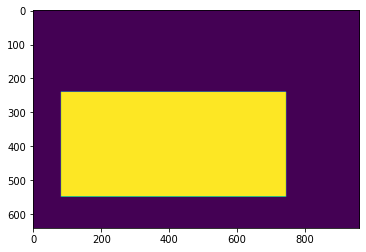

In [78]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label']
plt.imshow(gt_seg)

In [79]:
from torch import nn

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

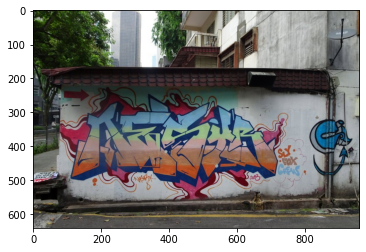

In [84]:
plt.imshow(image)

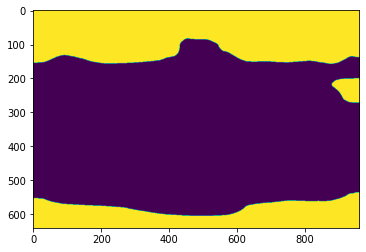

In [83]:
plt.imshow(pred_seg)

In [ ]:
# image = Image.open(os.path.join(img_dir, img['file_name']))

# catIds = coco.getCatIds(catNms=['graf'])
# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco.loadAnns(annIds)

# mask = coco.annToMask(anns[0])
# for i in range(len(anns)):
#     mask += coco.annToMask(anns[i])
# mask = np.where(mask != 0, 1, 0)

# gt_seg = mask
# plt.imshow(image)

In [ ]:

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# # First, rescale logits to original image size
# upsampled_logits = nn.functional.interpolate(
#     logits,
#     size=image.size[::-1], # (height, width)
#     mode='bilinear',
#     align_corners=False
# )

# # Second, apply argmax on the class dimension
# pred_seg = upsampled_logits.argmax(dim=1)[0]
# print(pred_seg)

In [ ]:
# plt.imshow(np.where(pred_seg == 0, 1, 0), cmap="gray")
# print(set(np.array(pred_seg.flatten())))